In [20]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import timm

from importlib import reload

logging.basicConfig(level=logging.ERROR)

from module import preprocess_lib, datasets_lib, utils_lib, models_lib, learning_lib, config_lib
reload(config_lib)



<module 'module.config_lib' from '/root/program/birdclef-2025/scripts/module/config_lib.py'>

In [21]:
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330' 
            
            # kaggle notebookならここを変更する．
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            self.train_datadir = '../data/raw/train_audio/'
            
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"

            # ローカルならここを変更する．
            self.train_csv = '../data/processed/mel_cleaned_0419/train.csv'
            self.spectrogram_npy = '../data/processed/mel_cleaned_0419/birdclef2025_melspec_5sec_256_256.npy'
            
            self.pretrained_model_path = "../models/fold0_pretrain_v2b2/model_fold0.pth"
            

        # ===== Model Settings =====
        self.model_name = 'tf_efficientnetv2_b3' # tf_efficientnetv2_b3
        self.pretrained = False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5.0 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        
        # trainer内部で決まるのでここでは指定しない．
        self.num_classes = None


        # ===== Training Mode =====
        if mode == "train":
            self.seed = 42
            self.apex = False
            self.print_freq = 100
            self.num_workers = 2

            self.LOAD_DATA = True
            self.epochs = 3
            self.batch_size = 32
            self.criterion = 'BCEWithLogitsLoss'

            self.n_fold = 5
            self.selected_folds = [0] # 学習に使うfold

            self.optimizer = 'AdamW'
            self.lr = 5e-4
            self.weight_decay = 1e-5
            self.scheduler = 'CosineAnnealingLR'
            self.min_lr = 1e-6
            self.T_max = self.epochs
            
           
            
            ## 現状使ってない．
            self.aug_prob = 0.5
            self.mixup_alpha_real = 0.5
            self.mixup_alpha_pseudo = 0.5
            self.use_pseudo_mixup = False  # pseudo lableでmixupするかどうか
            self.pseudo_mix_prob = 0.4  # mixupでpseudo lableを使う確率
            self.pseudo_conf_threshold = 0.5
            self.full_train = False
            ###
            
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            
            if self.debug:
                self.epochs = 2
                self.selected_folds = [0]
                self.batch_size = 4
                

In [22]:
cfg = CFG(mode="train", kaggle_notebook=False, debug=False)

In [23]:
utils_lib.set_seed(cfg.seed)

In [24]:
# trainの処理をクラスで実行．
class BirdCLEFTrainer:
    def __init__(self, cfg, df, taxonomy_df, datasets_lib, models_lib, learning_lib):
        self.cfg = cfg
        self.df = df.head(100).reset_index(drop=True) if cfg.debug else df
        self.taxonomy_df = taxonomy_df
        self.datasets_lib = datasets_lib
        self.models_lib = models_lib
        self.learning_lib = learning_lib
        self.spectrograms = None
        self.pseudo_df = None
        self.pseudo_melspecs = None
        self.best_scores = []
        self.train_metrics = {}
        self.val_metrics = {}
        self.label2index = {}
        self.index2label = {}
        self.num_classes = None

        self._setup_model_dir()
        self._save_config()
        self._build_index_label_mapping()
        self._load_spectrograms()
        
        if self.cfg.use_pseudo_mixup:
            self._load_pseudo_data()

    def _setup_model_dir(self):
        if self.cfg.debug:
            current_time = "debug"
            self.cfg.model_path = os.path.join(self.cfg.models_dir, "models_debug")
        else:
            japan_time = datetime.now(timezone(timedelta(hours=9)))
            current_time = japan_time.strftime('%Y%m%d_%H%M')
            self.cfg.model_path = os.path.join(self.cfg.models_dir, f"models_{current_time}")

        os.makedirs(self.cfg.model_path, exist_ok=True)
        print(f"[INFO] Models will be saved to: {self.cfg.model_path}")

        # dataset-metadata.jsonを保存
        dataset_metadata = {
            "title": f"bc25-models-{current_time}",
            "id": f"ihiratch/bc25-models-{current_time}",
            "licenses": [
                {
                    "name": "CC0-1.0"
                }
            ]
        }
        metadata_path = os.path.join(self.cfg.model_path, "dataset-metadata.json")
        with open(metadata_path, "w") as f:
            json.dump(dataset_metadata, f, indent=2)

    def _save_config(self):
        cfg_dict = vars(self.cfg)
        cfg_df = pd.DataFrame(list(cfg_dict.items()), columns=["key", "value"])
        cfg_df.to_csv(os.path.join(self.cfg.model_path, "config.csv"), index=False)

    def _build_index_label_mapping(self):
        species_ids = self.taxonomy_df['primary_label'].tolist()
        self.cfg.num_classes = len(species_ids)
        # labelとindexの対応
        self.index2label = {i: label for i, label in enumerate(species_ids)}
        self.label2index = {label: i for i, label in enumerate(species_ids)}

        print(self.index2label)

    def _load_spectrograms(self):
        print(f"Loading pre-computed mel spectrograms from NPY file, from the path: {self.cfg.spectrogram_npy}")
        self.spectrograms = np.load(self.cfg.spectrogram_npy, allow_pickle=True).item()
        print(f"Loaded {len(self.spectrograms)} pre-computed mel spectrograms")
        
    def _load_pseudo_data(self):
        print("📥 Loading pseudo label CSV and melspecs...")

        # row_id を index にして読み込む（← ここがポイント！）
        self.pseudo_df = pd.read_csv(self.cfg.pseudo_label_csv, index_col="row_id")

        # 信頼度フィルタリング（例: 最大値が 0.5 未満の行を除く）
        confidence_threshold = self.cfg.pseudo_conf_threshold
        max_probs = self.pseudo_df.max(axis=1)
        self.pseudo_df = self.pseudo_df[max_probs > confidence_threshold]
        self.pseudo_df = self.pseudo_df.reset_index(drop=False)
        print(f"✅ Filtered pseudo labels: {len(self.pseudo_df)}")

        # melspec は key が row_id の dict を想定
        self.pseudo_melspecs = np.load(self.cfg.pseudo_melspec_npy, allow_pickle=True)
        print(f"✅ Loaded pseudo mel-spectrograms: {len(self.pseudo_melspecs)}")
        
    def _create_train_dataset(self, train_df):
        if self.cfg.use_pseudo_mixup:
            print("🔀 Using BirdCLEFDatasetWithPseudo (with pseudo label mixup)")
            return self.datasets_lib.BirdCLEFDatasetWithPseudo(
                train_df=train_df,
                pseudo_df=self.pseudo_df,
                cfg=self.cfg,
                spectrograms=self.spectrograms,
                pseudo_melspecs=self.pseudo_melspecs,
                mode='train'
            )
        else:
            print("📦 Using BirdCLEFDatasetFromNPY (no pseudo mixup)")

            return self.datasets_lib.BirdCLEFDatasetFromNPY_Labeled(
                    df=train_df,
                    cfg=self.cfg,
                    spectrograms=self.spectrograms,
                    mode="train",
                    label2idx=self.label2index,
                    idx2label=self.index2label 
                    )
            

    def _calculate_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # 👇 ROC AUC はバイナリラベルを必要とするので、soft labelを2値化
        targets_bin = (targets >= 0.5).astype(int)

        aucs = [roc_auc_score(targets_bin[:, i], probs[:, i]) 
                for i in range(targets.shape[1]) if np.sum(targets_bin[:, i]) > 0]
        return np.mean(aucs) if aucs else 0.0

    def _calculate_classwise_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # バイナリ化（連続値でもintでも安全）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_auc = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_auc[i] = roc_auc_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_auc[i] = np.nan  # エラー出たときも安心
        return classwise_auc

    def _calculate_classwise_ap(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # ラベルをバイナリ化（soft label対応）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_ap = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_ap[i] = average_precision_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_ap[i] = np.nan
        return classwise_ap
    
    def _calculate_map(self, targets, outputs):
        classwise_ap = self._calculate_classwise_ap(targets, outputs)
        values = [v for v in classwise_ap.values() if v is not None and not np.isnan(v)]
        return np.mean(values) if values else 0.0

    def _save_classwise_scores_to_csv(self, classwise_auc, classwise_ap, fold, filename_prefix):
        rows = []
        for i in classwise_auc:
            label = self.index2label.get(i, str(i))
            auc = classwise_auc[i]
            ap = classwise_ap.get(i, np.nan)
            rows.append({"label": label, "val_auc": auc, "val_ap": ap})
        df = pd.DataFrame(rows)
        df.to_csv(os.path.join(self.cfg.model_path, f"{filename_prefix}_classwise_score_fold{fold}.csv"), index=False)


    def train_one_epoch(self, model, loader, optimizer, criterion, device, scheduler=None):
        model.train()
        losses, all_targets, all_outputs = [], [], []

        pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
        for step, batch in pbar:
            if isinstance(batch['melspec'], list):
                batch_outputs, batch_losses = [], []
                for i in range(len(batch['melspec'])):
                    inputs = batch['melspec'][i].unsqueeze(0).to(device)
                    target = batch['target'][i].unsqueeze(0).to(device)
                    optimizer.zero_grad()
            
                    output = model(inputs)
                    loss = criterion(output, target)
                    loss.backward()
                    batch_outputs.append(output.detach().cpu())
                    batch_losses.append(loss.item())
                optimizer.step()
                outputs = torch.cat(batch_outputs, dim=0).numpy()
                loss = np.mean(batch_losses)
                targets = batch['target'].numpy()
            else:
                inputs = batch['melspec'].to(device)
                targets = batch['target'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = outputs[1] if isinstance(outputs, tuple) else criterion(outputs, targets)
                outputs = outputs[0] if isinstance(outputs, tuple) else outputs
                loss.backward()
                optimizer.step()
                outputs = outputs.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()

            if scheduler and isinstance(scheduler, lr_scheduler.OneCycleLR):
                scheduler.step()

            all_outputs.append(outputs)
            all_targets.append(targets)
            losses.append(loss.item() if not isinstance(loss, float) else loss)

            pbar.set_postfix({
                'train_loss': np.mean(losses[-10:]) if losses else 0,
                'lr': optimizer.param_groups[0]['lr']
            })

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        self.train_metrics = {
            'train_loss': np.mean(losses),
            'train_auc': self._calculate_auc(all_targets, all_outputs),
            "train_map": self._calculate_map(all_targets, all_outputs),   
            "train_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "train_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),  
        }

    def validate(self, model, loader, criterion, device):
        model.eval()
        losses, all_targets, all_outputs = [], [], []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Validation"):
                if isinstance(batch['melspec'], list):
                    batch_outputs, batch_losses = [], []
                    for i in range(len(batch['melspec'])):
                        inputs = batch['melspec'][i].unsqueeze(0).to(device)
                        target = batch['target'][i].unsqueeze(0).to(device)
                        output = model(inputs)
                        loss = criterion(output, target)
                        batch_outputs.append(output.detach().cpu())
                        batch_losses.append(loss.item())
                    outputs = torch.cat(batch_outputs, dim=0).numpy()
                    loss = np.mean(batch_losses)
                    targets = batch['target'].numpy()
                else:
                    inputs = batch['melspec'].to(device)
                    targets = batch['target'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    outputs = outputs.detach().cpu().numpy()
                    targets = targets.detach().cpu().numpy()

                all_outputs.append(outputs)
                all_targets.append(targets)
                losses.append(loss.item() if not isinstance(loss, float) else loss)

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        # print("Size of validation:",  len(all_targets))
        self.val_metrics = {
            'val_loss': np.mean(losses),
            'val_auc': self._calculate_auc(all_targets, all_outputs),
            "val_map": self._calculate_map(all_targets, all_outputs),
            "val_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "val_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),
        }

    def run(self):
        
        for fold in range(self.cfg.n_fold):
            if fold not in self.cfg.selected_folds:
                continue
            print(f"\n{'='*30} Fold {fold} {'='*30}")

            # train.csvのfoldを使う．
            
            if self.cfg.full_train:
                train_df = self.df.reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True)
                print("Use full train data for training.")
            else:
                train_df = self.df[self.df['fold'] != fold].reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True) 
            
            print(f"Training set: {len(train_df)} samples")
            print(f"Validation set: {len(val_df)} samples")

            train_dataset = self._create_train_dataset(train_df)
            val_dataset = self.datasets_lib.BirdCLEFDatasetFromNPY_Labeled(
                        df=val_df,
                        cfg=self.cfg,
                        spectrograms=self.spectrograms,
                        mode='valid',
                        label2idx=self.label2index,
                        idx2label=self.index2label
                    )

            train_loader = DataLoader(train_dataset, batch_size=self.cfg.batch_size, shuffle=True, 
                                       num_workers=self.cfg.num_workers, pin_memory=True,
                                       collate_fn=self.datasets_lib.collate_fn, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=self.cfg.batch_size, shuffle=False,
                                     num_workers=self.cfg.num_workers, pin_memory=True,
                                     collate_fn=self.datasets_lib.collate_fn)

            model = self.models_lib.BirdCLEFModelForTrain(self.cfg).to(self.cfg.device)
            
            print(f"🔄 Loading pretrained weights from {self.cfg.pretrained_model_path}")
            state = torch.load(self.cfg.pretrained_model_path, map_location=self.cfg.device)
            pretrained_dict = state["model_state_dict"]

            # 出力層を除外
            filtered_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith("classifier.")}
            
            model.load_state_dict(filtered_dict, strict=False)
            print("✅ Pretrained weights loaded (excluding classifier)")
                    
            optimizer = self.learning_lib.get_optimizer(model, self.cfg)
            criterion = self.learning_lib.get_criterion(self.cfg)

            scheduler = (lr_scheduler.OneCycleLR(optimizer, max_lr=self.cfg.lr, 
                        steps_per_epoch=len(train_loader), epochs=self.cfg.epochs, pct_start=0.1)
                         if self.cfg.scheduler == 'OneCycleLR'
                         else self.learning_lib.get_scheduler(optimizer, self.cfg))

            best_auc = 0
            log_history = []

            for epoch in range(self.cfg.epochs):
                print(f"\nEpoch {epoch+1}/{self.cfg.epochs}")
                start_time = time.time()

                self.train_one_epoch(model, train_loader, optimizer, criterion, self.cfg.device, scheduler if isinstance(scheduler, lr_scheduler.OneCycleLR) else None)
                self.validate(model, val_loader, criterion, self.cfg.device)

                # スコア取得
                train_loss = self.train_metrics['train_loss']
                train_auc = self.train_metrics['train_auc']
                train_auc_map = self.train_metrics['train_map']

                val_loss = self.val_metrics['val_loss']
                val_auc = self.val_metrics['val_auc']
                val_auc_map = self.val_metrics['val_map']
                val_classwise_auc = self.val_metrics['val_classwise_auc']
                val_classwise_ap = self.val_metrics['val_classwise_ap']

                if scheduler and not isinstance(scheduler, lr_scheduler.OneCycleLR):
                    scheduler.step(val_loss if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau) else None)

                print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train MAP: {train_auc_map:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val MAP: {val_auc_map:.4f}")

                if val_auc > best_auc:
                    best_auc = val_auc
                    print(f"New best AUC: {best_auc:.4f} at epoch {epoch+1}")
                    
                    self._save_classwise_scores_to_csv(val_classwise_auc, val_classwise_ap, fold, filename_prefix="best_val")

                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'epoch': epoch,
                        'val_auc': val_auc,
                        'train_auc': train_auc,
                        "index2label": self.index2label,
                        'cfg': self.cfg
                    }, f"{self.cfg.model_path}/model_fold{fold}.pth")

                log_entry = {
                    'epoch': epoch + 1,
                    'lr': scheduler.get_last_lr()[0] if scheduler else self.cfg.lr,
                    'epoch_time_min': round((time.time() - start_time) / 60, 2)
                }

                # classwiseスコアを除外した val_metrics のログ
                train_log = {f"{k}": v for k, v in self.train_metrics.items() if not k.startswith("train_classwise")}
                val_log = {f"{k}": v for k, v in self.val_metrics.items() if not k.startswith("val_classwise")}
                
                # ログ用スコアの更新（classwiseは除外）
                log_entry.update(train_log)
                log_entry.update(val_log)
                log_history.append(log_entry)
            
           
                

            pd.DataFrame(log_history).to_csv(f"{self.cfg.model_path}/log_fold{fold}.csv", index=False)
            self.best_scores.append(best_auc)
            print(f"\nBest AUC for fold {fold}: {best_auc:.4f}")

            del model, optimizer, scheduler, train_loader, val_loader
            torch.cuda.empty_cache()
            gc.collect()

        print("\n" + "="*60)
        print("Cross-Validation Results:")
        for fold, score in enumerate(self.best_scores):
            print(f"Fold {self.cfg.selected_folds[fold]}: {score:.4f}")
        print(f"Mean AUC: {np.mean(self.best_scores):.4f}")
        print("="*60)



In [25]:
# モデルはmodels_{current_time}に保存される．
if __name__ == "__main__":
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)
    # taxonomyはラベルとindexの対応を取るために必要．
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
    print("\nStarting training...")
    trainer = BirdCLEFTrainer(cfg, train_df, taxonomy_df,  datasets_lib, models_lib, learning_lib)
    trainer.run()
    print("\nTraining complete!")


Loading training data...

Starting training...
[INFO] Models will be saved to: ../models/models_20250428_2352
{0: '1139490', 1: '1192948', 2: '1194042', 3: '126247', 4: '1346504', 5: '134933', 6: '135045', 7: '1462711', 8: '1462737', 9: '1564122', 10: '21038', 11: '21116', 12: '21211', 13: '22333', 14: '22973', 15: '22976', 16: '24272', 17: '24292', 18: '24322', 19: '41663', 20: '41778', 21: '41970', 22: '42007', 23: '42087', 24: '42113', 25: '46010', 26: '47067', 27: '476537', 28: '476538', 29: '48124', 30: '50186', 31: '517119', 32: '523060', 33: '528041', 34: '52884', 35: '548639', 36: '555086', 37: '555142', 38: '566513', 39: '64862', 40: '65336', 41: '65344', 42: '65349', 43: '65373', 44: '65419', 45: '65448', 46: '65547', 47: '65962', 48: '66016', 49: '66531', 50: '66578', 51: '66893', 52: '67082', 53: '67252', 54: '714022', 55: '715170', 56: '787625', 57: '81930', 58: '868458', 59: '963335', 60: 'amakin1', 61: 'amekes', 62: 'ampkin1', 63: 'anhing', 64: 'babwar', 65: 'bafibi1', 

Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0245, Train AUC: 0.8136, Train MAP: 0.1394
Val Loss: 0.0161, Val AUC: 0.9397, Val MAP: 0.4558
New best AUC: 0.9397 at epoch 1

Epoch 2/3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0144, Train AUC: 0.9502, Train MAP: 0.4063
Val Loss: 0.0147, Val AUC: 0.9522, Val MAP: 0.5391
New best AUC: 0.9522 at epoch 2

Epoch 3/3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0106, Train AUC: 0.9797, Train MAP: 0.5892
Val Loss: 0.0135, Val AUC: 0.9575, Val MAP: 0.5782
New best AUC: 0.9575 at epoch 3

Best AUC for fold 0: 0.9575

Cross-Validation Results:
Fold 0: 0.9575
Mean AUC: 0.9575

Training complete!


In [31]:
import os
model_dir_name = "fold0_finetuned_v2b2_epch3"
model_dir = os.path.join(cfg.models_dir, model_dir_name)

# スコア格納辞書（foldごとの記録）
score_lists = {
    'val_auc': [],
    'train_auc': [],
    'val_map': [],
    'train_map': [],
    'val_loss': [],
    'train_loss': [],
    'epoch': [],
}

# 各foldのベストスコア収集
for fold in range(5):
    log_path = os.path.join(model_dir, f"log_fold{fold}.csv")
    if not os.path.exists(log_path):
        print(f"Missing log for fold {fold}: {log_path}")
        continue

    df = pd.read_csv(log_path)
    best_row = df.loc[df['val_auc'].idxmax()]

    print(f"Fold {fold} best epoch: {int(best_row['epoch'])}, val_auc: {best_row['val_auc']:.3f}, train_auc: {best_row['train_auc']:.3f}")

    for key in score_lists:
        score_lists[key].append(best_row[key])

# 平均スコアを整形（.3fで表示、epochだけ.2f）
score_means = {}
for key, values in score_lists.items():
    avg = sum(values) / len(values)
    display_key = f"Avg {key.replace('_', ' ').title()}"
    if "epoch" in key:
        score_means[display_key] = f"{avg:.2f}"
    else:
        score_means[display_key] = f"{avg:.3f}"

# config.csv 読み込み
config_path = os.path.join(model_dir, "config.csv")
config_df = pd.read_csv(config_path)

important_keys = [
    'model_name','batch_size', 'epochs',
    'optimizer', 'lr', 'weight_decay', 'scheduler', 'min_lr', "tta",
]

# config情報の統合
config_dict = {"Note": "", "LB AUC": "", **score_means }
for key in important_keys:
    value = config_df.loc[config_df['key'] == key, 'value'].values
    config_dict[key] = value[0] if len(value) > 0 else ""

# Markdown出力
all_keys = list(config_dict.keys())
print("\n```markdown")
print("| " + " | ".join(all_keys) + " |")
print("|" + "|".join(["-" * (len(k)+2) for k in all_keys]) + "|")
print("| " + " | ".join(str(config_dict[k]) for k in all_keys) + " |")
print("```")

Fold 0 best epoch: 3, val_auc: 0.958, train_auc: 0.980
Missing log for fold 1: ../models/fold0_finetuned_v2b2_epch3/log_fold1.csv
Missing log for fold 2: ../models/fold0_finetuned_v2b2_epch3/log_fold2.csv
Missing log for fold 3: ../models/fold0_finetuned_v2b2_epch3/log_fold3.csv
Missing log for fold 4: ../models/fold0_finetuned_v2b2_epch3/log_fold4.csv

```markdown
| Note | LB AUC | Avg Val Auc | Avg Train Auc | Avg Val Map | Avg Train Map | Avg Val Loss | Avg Train Loss | Avg Epoch | model_name | batch_size | epochs | optimizer | lr | weight_decay | scheduler | min_lr | tta |
|------|--------|-------------|---------------|-------------|---------------|--------------|----------------|-----------|------------|------------|--------|-----------|----|--------------|-----------|--------|-----|
|  |  | 0.958 | 0.980 | 0.578 | 0.589 | 0.014 | 0.011 | 3.00 | tf_efficientnetv2_b3 | 32 | 3 | AdamW | 0.0005 | 1e-05 | CosineAnnealingLR | 1e-06 |  |
```


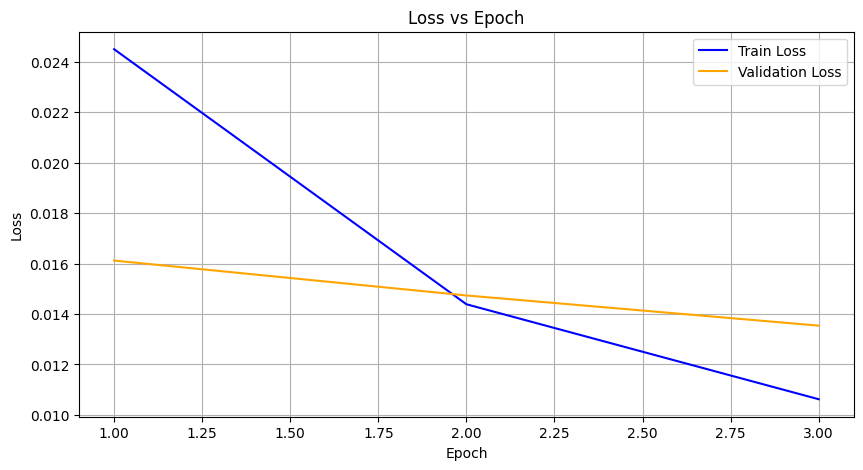

In [30]:
model_dir_name = "fold0_finetuned_v2b2_epch3"
i = 0
model_dir = os.path.join(cfg.models_dir, model_dir_name)
log_path = os.path.join(model_dir, f"log_fold{i}.csv")

# lossをプロット
df = pd.read_csv(log_path)
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [28]:
# モデル出力チェック

# モデルパス
# 比較元
model_1_path = "../models/epch1_cleaned_0413/model_fold0.pth"
model_2_path = "../models/models_20250422_1833/model_fold0.pth"

# 共通設定（このcfg_infは必須）
cfg_inf = CFG(mode="inference", kaggle_notebook=False)
num_classes = train_df['primary_label'].nunique()


# モデル読み込み関数
def load_model(path):
    model = models_lib.BirdCLEFModelForInference(cfg_inf, num_classes)
    checkpoint = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

# モデル読み込み
model_1 = load_model(model_1_path)
model_2 = load_model(model_2_path)

# 同じダミー入力
dummy_input = torch.randn(1, 1, 256, 256)

# 推論（出力に sigmoid が必要な場合は model に含まれてるか確認して適宜追加）
with torch.no_grad():
    out_0413 = model_1(dummy_input).numpy()
    out_0420 = model_2(dummy_input).numpy()

# 差分計算
abs_diff = np.abs(out_0413 - out_0420)
print("🔍 PyTorch モデル出力比較:")
print(f"最大誤差: {np.max(abs_diff)}")
print(f"平均誤差: {np.mean(abs_diff)}")
print(f"標準偏差: {np.std(abs_diff)}")

RuntimeError: Error(s) in loading state_dict for BirdCLEFModelForInference:
	Missing key(s) in state_dict: "backbone.blocks.0.0.conv.weight", "backbone.blocks.0.1.conv.weight", "backbone.blocks.0.1.bn1.weight", "backbone.blocks.0.1.bn1.bias", "backbone.blocks.0.1.bn1.running_mean", "backbone.blocks.0.1.bn1.running_var", "backbone.blocks.1.0.conv_exp.weight", "backbone.blocks.1.1.conv_exp.weight", "backbone.blocks.1.2.conv_exp.weight", "backbone.blocks.1.2.bn1.weight", "backbone.blocks.1.2.bn1.bias", "backbone.blocks.1.2.bn1.running_mean", "backbone.blocks.1.2.bn1.running_var", "backbone.blocks.1.2.conv_pwl.weight", "backbone.blocks.1.2.bn2.weight", "backbone.blocks.1.2.bn2.bias", "backbone.blocks.1.2.bn2.running_mean", "backbone.blocks.1.2.bn2.running_var", "backbone.blocks.2.0.conv_exp.weight", "backbone.blocks.2.1.conv_exp.weight", "backbone.blocks.2.2.conv_exp.weight", "backbone.blocks.2.2.bn1.weight", "backbone.blocks.2.2.bn1.bias", "backbone.blocks.2.2.bn1.running_mean", "backbone.blocks.2.2.bn1.running_var", "backbone.blocks.2.2.conv_pwl.weight", "backbone.blocks.2.2.bn2.weight", "backbone.blocks.2.2.bn2.bias", "backbone.blocks.2.2.bn2.running_mean", "backbone.blocks.2.2.bn2.running_var", "backbone.blocks.3.3.conv_pw.weight", "backbone.blocks.3.3.bn1.weight", "backbone.blocks.3.3.bn1.bias", "backbone.blocks.3.3.bn1.running_mean", "backbone.blocks.3.3.bn1.running_var", "backbone.blocks.3.3.conv_dw.weight", "backbone.blocks.3.3.bn2.weight", "backbone.blocks.3.3.bn2.bias", "backbone.blocks.3.3.bn2.running_mean", "backbone.blocks.3.3.bn2.running_var", "backbone.blocks.3.3.se.conv_reduce.weight", "backbone.blocks.3.3.se.conv_reduce.bias", "backbone.blocks.3.3.se.conv_expand.weight", "backbone.blocks.3.3.se.conv_expand.bias", "backbone.blocks.3.3.conv_pwl.weight", "backbone.blocks.3.3.bn3.weight", "backbone.blocks.3.3.bn3.bias", "backbone.blocks.3.3.bn3.running_mean", "backbone.blocks.3.3.bn3.running_var", "backbone.blocks.3.4.conv_pw.weight", "backbone.blocks.3.4.bn1.weight", "backbone.blocks.3.4.bn1.bias", "backbone.blocks.3.4.bn1.running_mean", "backbone.blocks.3.4.bn1.running_var", "backbone.blocks.3.4.conv_dw.weight", "backbone.blocks.3.4.bn2.weight", "backbone.blocks.3.4.bn2.bias", "backbone.blocks.3.4.bn2.running_mean", "backbone.blocks.3.4.bn2.running_var", "backbone.blocks.3.4.se.conv_reduce.weight", "backbone.blocks.3.4.se.conv_reduce.bias", "backbone.blocks.3.4.se.conv_expand.weight", "backbone.blocks.3.4.se.conv_expand.bias", "backbone.blocks.3.4.conv_pwl.weight", "backbone.blocks.3.4.bn3.weight", "backbone.blocks.3.4.bn3.bias", "backbone.blocks.3.4.bn3.running_mean", "backbone.blocks.3.4.bn3.running_var", "backbone.blocks.4.3.conv_pw.weight", "backbone.blocks.4.3.bn1.weight", "backbone.blocks.4.3.bn1.bias", "backbone.blocks.4.3.bn1.running_mean", "backbone.blocks.4.3.bn1.running_var", "backbone.blocks.4.3.conv_dw.weight", "backbone.blocks.4.3.bn2.weight", "backbone.blocks.4.3.bn2.bias", "backbone.blocks.4.3.bn2.running_mean", "backbone.blocks.4.3.bn2.running_var", "backbone.blocks.4.3.se.conv_reduce.weight", "backbone.blocks.4.3.se.conv_reduce.bias", "backbone.blocks.4.3.se.conv_expand.weight", "backbone.blocks.4.3.se.conv_expand.bias", "backbone.blocks.4.3.conv_pwl.weight", "backbone.blocks.4.3.bn3.weight", "backbone.blocks.4.3.bn3.bias", "backbone.blocks.4.3.bn3.running_mean", "backbone.blocks.4.3.bn3.running_var", "backbone.blocks.4.4.conv_pw.weight", "backbone.blocks.4.4.bn1.weight", "backbone.blocks.4.4.bn1.bias", "backbone.blocks.4.4.bn1.running_mean", "backbone.blocks.4.4.bn1.running_var", "backbone.blocks.4.4.conv_dw.weight", "backbone.blocks.4.4.bn2.weight", "backbone.blocks.4.4.bn2.bias", "backbone.blocks.4.4.bn2.running_mean", "backbone.blocks.4.4.bn2.running_var", "backbone.blocks.4.4.se.conv_reduce.weight", "backbone.blocks.4.4.se.conv_reduce.bias", "backbone.blocks.4.4.se.conv_expand.weight", "backbone.blocks.4.4.se.conv_expand.bias", "backbone.blocks.4.4.conv_pwl.weight", "backbone.blocks.4.4.bn3.weight", "backbone.blocks.4.4.bn3.bias", "backbone.blocks.4.4.bn3.running_mean", "backbone.blocks.4.4.bn3.running_var", "backbone.blocks.4.5.conv_pw.weight", "backbone.blocks.4.5.bn1.weight", "backbone.blocks.4.5.bn1.bias", "backbone.blocks.4.5.bn1.running_mean", "backbone.blocks.4.5.bn1.running_var", "backbone.blocks.4.5.conv_dw.weight", "backbone.blocks.4.5.bn2.weight", "backbone.blocks.4.5.bn2.bias", "backbone.blocks.4.5.bn2.running_mean", "backbone.blocks.4.5.bn2.running_var", "backbone.blocks.4.5.se.conv_reduce.weight", "backbone.blocks.4.5.se.conv_reduce.bias", "backbone.blocks.4.5.se.conv_expand.weight", "backbone.blocks.4.5.se.conv_expand.bias", "backbone.blocks.4.5.conv_pwl.weight", "backbone.blocks.4.5.bn3.weight", "backbone.blocks.4.5.bn3.bias", "backbone.blocks.4.5.bn3.running_mean", "backbone.blocks.4.5.bn3.running_var", "backbone.blocks.4.6.conv_pw.weight", "backbone.blocks.4.6.bn1.weight", "backbone.blocks.4.6.bn1.bias", "backbone.blocks.4.6.bn1.running_mean", "backbone.blocks.4.6.bn1.running_var", "backbone.blocks.4.6.conv_dw.weight", "backbone.blocks.4.6.bn2.weight", "backbone.blocks.4.6.bn2.bias", "backbone.blocks.4.6.bn2.running_mean", "backbone.blocks.4.6.bn2.running_var", "backbone.blocks.4.6.se.conv_reduce.weight", "backbone.blocks.4.6.se.conv_reduce.bias", "backbone.blocks.4.6.se.conv_expand.weight", "backbone.blocks.4.6.se.conv_expand.bias", "backbone.blocks.4.6.conv_pwl.weight", "backbone.blocks.4.6.bn3.weight", "backbone.blocks.4.6.bn3.bias", "backbone.blocks.4.6.bn3.running_mean", "backbone.blocks.4.6.bn3.running_var", "backbone.blocks.5.4.conv_pw.weight", "backbone.blocks.5.4.bn1.weight", "backbone.blocks.5.4.bn1.bias", "backbone.blocks.5.4.bn1.running_mean", "backbone.blocks.5.4.bn1.running_var", "backbone.blocks.5.4.conv_dw.weight", "backbone.blocks.5.4.bn2.weight", "backbone.blocks.5.4.bn2.bias", "backbone.blocks.5.4.bn2.running_mean", "backbone.blocks.5.4.bn2.running_var", "backbone.blocks.5.4.se.conv_reduce.weight", "backbone.blocks.5.4.se.conv_reduce.bias", "backbone.blocks.5.4.se.conv_expand.weight", "backbone.blocks.5.4.se.conv_expand.bias", "backbone.blocks.5.4.conv_pwl.weight", "backbone.blocks.5.4.bn3.weight", "backbone.blocks.5.4.bn3.bias", "backbone.blocks.5.4.bn3.running_mean", "backbone.blocks.5.4.bn3.running_var", "backbone.blocks.5.5.conv_pw.weight", "backbone.blocks.5.5.bn1.weight", "backbone.blocks.5.5.bn1.bias", "backbone.blocks.5.5.bn1.running_mean", "backbone.blocks.5.5.bn1.running_var", "backbone.blocks.5.5.conv_dw.weight", "backbone.blocks.5.5.bn2.weight", "backbone.blocks.5.5.bn2.bias", "backbone.blocks.5.5.bn2.running_mean", "backbone.blocks.5.5.bn2.running_var", "backbone.blocks.5.5.se.conv_reduce.weight", "backbone.blocks.5.5.se.conv_reduce.bias", "backbone.blocks.5.5.se.conv_expand.weight", "backbone.blocks.5.5.se.conv_expand.bias", "backbone.blocks.5.5.conv_pwl.weight", "backbone.blocks.5.5.bn3.weight", "backbone.blocks.5.5.bn3.bias", "backbone.blocks.5.5.bn3.running_mean", "backbone.blocks.5.5.bn3.running_var", "backbone.blocks.5.6.conv_pw.weight", "backbone.blocks.5.6.bn1.weight", "backbone.blocks.5.6.bn1.bias", "backbone.blocks.5.6.bn1.running_mean", "backbone.blocks.5.6.bn1.running_var", "backbone.blocks.5.6.conv_dw.weight", "backbone.blocks.5.6.bn2.weight", "backbone.blocks.5.6.bn2.bias", "backbone.blocks.5.6.bn2.running_mean", "backbone.blocks.5.6.bn2.running_var", "backbone.blocks.5.6.se.conv_reduce.weight", "backbone.blocks.5.6.se.conv_reduce.bias", "backbone.blocks.5.6.se.conv_expand.weight", "backbone.blocks.5.6.se.conv_expand.bias", "backbone.blocks.5.6.conv_pwl.weight", "backbone.blocks.5.6.bn3.weight", "backbone.blocks.5.6.bn3.bias", "backbone.blocks.5.6.bn3.running_mean", "backbone.blocks.5.6.bn3.running_var", "backbone.blocks.5.7.conv_pw.weight", "backbone.blocks.5.7.bn1.weight", "backbone.blocks.5.7.bn1.bias", "backbone.blocks.5.7.bn1.running_mean", "backbone.blocks.5.7.bn1.running_var", "backbone.blocks.5.7.conv_dw.weight", "backbone.blocks.5.7.bn2.weight", "backbone.blocks.5.7.bn2.bias", "backbone.blocks.5.7.bn2.running_mean", "backbone.blocks.5.7.bn2.running_var", "backbone.blocks.5.7.se.conv_reduce.weight", "backbone.blocks.5.7.se.conv_reduce.bias", "backbone.blocks.5.7.se.conv_expand.weight", "backbone.blocks.5.7.se.conv_expand.bias", "backbone.blocks.5.7.conv_pwl.weight", "backbone.blocks.5.7.bn3.weight", "backbone.blocks.5.7.bn3.bias", "backbone.blocks.5.7.bn3.running_mean", "backbone.blocks.5.7.bn3.running_var", "backbone.blocks.5.8.conv_pw.weight", "backbone.blocks.5.8.bn1.weight", "backbone.blocks.5.8.bn1.bias", "backbone.blocks.5.8.bn1.running_mean", "backbone.blocks.5.8.bn1.running_var", "backbone.blocks.5.8.conv_dw.weight", "backbone.blocks.5.8.bn2.weight", "backbone.blocks.5.8.bn2.bias", "backbone.blocks.5.8.bn2.running_mean", "backbone.blocks.5.8.bn2.running_var", "backbone.blocks.5.8.se.conv_reduce.weight", "backbone.blocks.5.8.se.conv_reduce.bias", "backbone.blocks.5.8.se.conv_expand.weight", "backbone.blocks.5.8.se.conv_expand.bias", "backbone.blocks.5.8.conv_pwl.weight", "backbone.blocks.5.8.bn3.weight", "backbone.blocks.5.8.bn3.bias", "backbone.blocks.5.8.bn3.running_mean", "backbone.blocks.5.8.bn3.running_var", "backbone.blocks.5.9.conv_pw.weight", "backbone.blocks.5.9.bn1.weight", "backbone.blocks.5.9.bn1.bias", "backbone.blocks.5.9.bn1.running_mean", "backbone.blocks.5.9.bn1.running_var", "backbone.blocks.5.9.conv_dw.weight", "backbone.blocks.5.9.bn2.weight", "backbone.blocks.5.9.bn2.bias", "backbone.blocks.5.9.bn2.running_mean", "backbone.blocks.5.9.bn2.running_var", "backbone.blocks.5.9.se.conv_reduce.weight", "backbone.blocks.5.9.se.conv_reduce.bias", "backbone.blocks.5.9.se.conv_expand.weight", "backbone.blocks.5.9.se.conv_expand.bias", "backbone.blocks.5.9.conv_pwl.weight", "backbone.blocks.5.9.bn3.weight", "backbone.blocks.5.9.bn3.bias", "backbone.blocks.5.9.bn3.running_mean", "backbone.blocks.5.9.bn3.running_var", "backbone.blocks.5.10.conv_pw.weight", "backbone.blocks.5.10.bn1.weight", "backbone.blocks.5.10.bn1.bias", "backbone.blocks.5.10.bn1.running_mean", "backbone.blocks.5.10.bn1.running_var", "backbone.blocks.5.10.conv_dw.weight", "backbone.blocks.5.10.bn2.weight", "backbone.blocks.5.10.bn2.bias", "backbone.blocks.5.10.bn2.running_mean", "backbone.blocks.5.10.bn2.running_var", "backbone.blocks.5.10.se.conv_reduce.weight", "backbone.blocks.5.10.se.conv_reduce.bias", "backbone.blocks.5.10.se.conv_expand.weight", "backbone.blocks.5.10.se.conv_expand.bias", "backbone.blocks.5.10.conv_pwl.weight", "backbone.blocks.5.10.bn3.weight", "backbone.blocks.5.10.bn3.bias", "backbone.blocks.5.10.bn3.running_mean", "backbone.blocks.5.10.bn3.running_var", "backbone.blocks.5.11.conv_pw.weight", "backbone.blocks.5.11.bn1.weight", "backbone.blocks.5.11.bn1.bias", "backbone.blocks.5.11.bn1.running_mean", "backbone.blocks.5.11.bn1.running_var", "backbone.blocks.5.11.conv_dw.weight", "backbone.blocks.5.11.bn2.weight", "backbone.blocks.5.11.bn2.bias", "backbone.blocks.5.11.bn2.running_mean", "backbone.blocks.5.11.bn2.running_var", "backbone.blocks.5.11.se.conv_reduce.weight", "backbone.blocks.5.11.se.conv_reduce.bias", "backbone.blocks.5.11.se.conv_expand.weight", "backbone.blocks.5.11.se.conv_expand.bias", "backbone.blocks.5.11.conv_pwl.weight", "backbone.blocks.5.11.bn3.weight", "backbone.blocks.5.11.bn3.bias", "backbone.blocks.5.11.bn3.running_mean", "backbone.blocks.5.11.bn3.running_var". 
	Unexpected key(s) in state_dict: "backbone.blocks.6.0.conv_pw.weight", "backbone.blocks.6.0.bn1.weight", "backbone.blocks.6.0.bn1.bias", "backbone.blocks.6.0.bn1.running_mean", "backbone.blocks.6.0.bn1.running_var", "backbone.blocks.6.0.bn1.num_batches_tracked", "backbone.blocks.6.0.conv_dw.weight", "backbone.blocks.6.0.bn2.weight", "backbone.blocks.6.0.bn2.bias", "backbone.blocks.6.0.bn2.running_mean", "backbone.blocks.6.0.bn2.running_var", "backbone.blocks.6.0.bn2.num_batches_tracked", "backbone.blocks.6.0.se.conv_reduce.weight", "backbone.blocks.6.0.se.conv_reduce.bias", "backbone.blocks.6.0.se.conv_expand.weight", "backbone.blocks.6.0.se.conv_expand.bias", "backbone.blocks.6.0.conv_pwl.weight", "backbone.blocks.6.0.bn3.weight", "backbone.blocks.6.0.bn3.bias", "backbone.blocks.6.0.bn3.running_mean", "backbone.blocks.6.0.bn3.running_var", "backbone.blocks.6.0.bn3.num_batches_tracked", "backbone.blocks.0.0.conv_dw.weight", "backbone.blocks.0.0.se.conv_reduce.weight", "backbone.blocks.0.0.se.conv_reduce.bias", "backbone.blocks.0.0.se.conv_expand.weight", "backbone.blocks.0.0.se.conv_expand.bias", "backbone.blocks.0.0.conv_pw.weight", "backbone.blocks.0.0.bn2.weight", "backbone.blocks.0.0.bn2.bias", "backbone.blocks.0.0.bn2.running_mean", "backbone.blocks.0.0.bn2.running_var", "backbone.blocks.0.0.bn2.num_batches_tracked", "backbone.blocks.1.0.conv_pw.weight", "backbone.blocks.1.0.conv_dw.weight", "backbone.blocks.1.0.bn3.weight", "backbone.blocks.1.0.bn3.bias", "backbone.blocks.1.0.bn3.running_mean", "backbone.blocks.1.0.bn3.running_var", "backbone.blocks.1.0.bn3.num_batches_tracked", "backbone.blocks.1.0.se.conv_reduce.weight", "backbone.blocks.1.0.se.conv_reduce.bias", "backbone.blocks.1.0.se.conv_expand.weight", "backbone.blocks.1.0.se.conv_expand.bias", "backbone.blocks.1.1.conv_pw.weight", "backbone.blocks.1.1.conv_dw.weight", "backbone.blocks.1.1.bn3.weight", "backbone.blocks.1.1.bn3.bias", "backbone.blocks.1.1.bn3.running_mean", "backbone.blocks.1.1.bn3.running_var", "backbone.blocks.1.1.bn3.num_batches_tracked", "backbone.blocks.1.1.se.conv_reduce.weight", "backbone.blocks.1.1.se.conv_reduce.bias", "backbone.blocks.1.1.se.conv_expand.weight", "backbone.blocks.1.1.se.conv_expand.bias", "backbone.blocks.2.0.conv_pw.weight", "backbone.blocks.2.0.conv_dw.weight", "backbone.blocks.2.0.bn3.weight", "backbone.blocks.2.0.bn3.bias", "backbone.blocks.2.0.bn3.running_mean", "backbone.blocks.2.0.bn3.running_var", "backbone.blocks.2.0.bn3.num_batches_tracked", "backbone.blocks.2.0.se.conv_reduce.weight", "backbone.blocks.2.0.se.conv_reduce.bias", "backbone.blocks.2.0.se.conv_expand.weight", "backbone.blocks.2.0.se.conv_expand.bias", "backbone.blocks.2.1.conv_pw.weight", "backbone.blocks.2.1.conv_dw.weight", "backbone.blocks.2.1.bn3.weight", "backbone.blocks.2.1.bn3.bias", "backbone.blocks.2.1.bn3.running_mean", "backbone.blocks.2.1.bn3.running_var", "backbone.blocks.2.1.bn3.num_batches_tracked", "backbone.blocks.2.1.se.conv_reduce.weight", "backbone.blocks.2.1.se.conv_reduce.bias", "backbone.blocks.2.1.se.conv_expand.weight", "backbone.blocks.2.1.se.conv_expand.bias". 
	size mismatch for backbone.conv_stem.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 1, 3, 3]).
	size mismatch for backbone.bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.0.0.bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.0.0.bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.0.0.bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.0.0.bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.1.0.bn1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.1.0.bn1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.1.0.bn1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.1.0.bn1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.1.0.conv_pwl.weight: copying a param with shape torch.Size([24, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 64, 1, 1]).
	size mismatch for backbone.blocks.1.0.bn2.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn2.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn2.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.1.1.bn1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.1.1.bn1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.1.1.bn1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.1.1.conv_pwl.weight: copying a param with shape torch.Size([24, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 160, 1, 1]).
	size mismatch for backbone.blocks.1.1.bn2.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn2.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn2.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.2.0.bn1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.2.0.bn1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.2.0.bn1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.2.0.bn1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for backbone.blocks.2.0.conv_pwl.weight: copying a param with shape torch.Size([40, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([56, 160, 1, 1]).
	size mismatch for backbone.blocks.2.0.bn2.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.0.bn2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.0.bn2.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.0.bn2.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.1.bn1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.2.1.bn1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.2.1.bn1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.2.1.bn1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.2.1.conv_pwl.weight: copying a param with shape torch.Size([40, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([56, 224, 1, 1]).
	size mismatch for backbone.blocks.2.1.bn2.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.1.bn2.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.1.bn2.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.2.1.bn2.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for backbone.blocks.3.0.conv_pw.weight: copying a param with shape torch.Size([240, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([224, 56, 1, 1]).
	size mismatch for backbone.blocks.3.0.bn1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.conv_dw.weight: copying a param with shape torch.Size([240, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([224, 1, 3, 3]).
	size mismatch for backbone.blocks.3.0.bn2.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn2.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn2.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.bn2.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.se.conv_reduce.weight: copying a param with shape torch.Size([10, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([14, 224, 1, 1]).
	size mismatch for backbone.blocks.3.0.se.conv_reduce.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([14]).
	size mismatch for backbone.blocks.3.0.se.conv_expand.weight: copying a param with shape torch.Size([240, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([224, 14, 1, 1]).
	size mismatch for backbone.blocks.3.0.se.conv_expand.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for backbone.blocks.3.0.conv_pwl.weight: copying a param with shape torch.Size([80, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 224, 1, 1]).
	size mismatch for backbone.blocks.3.0.bn3.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.0.bn3.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.0.bn3.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.0.bn3.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.1.conv_pw.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([448, 112, 1, 1]).
	size mismatch for backbone.blocks.3.1.bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.conv_dw.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([448, 1, 3, 3]).
	size mismatch for backbone.blocks.3.1.bn2.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn2.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.bn2.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.se.conv_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 448, 1, 1]).
	size mismatch for backbone.blocks.3.1.se.conv_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for backbone.blocks.3.1.se.conv_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([448, 28, 1, 1]).
	size mismatch for backbone.blocks.3.1.se.conv_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.1.conv_pwl.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 448, 1, 1]).
	size mismatch for backbone.blocks.3.1.bn3.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.1.bn3.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.1.bn3.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.1.bn3.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.2.conv_pw.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([448, 112, 1, 1]).
	size mismatch for backbone.blocks.3.2.bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.conv_dw.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([448, 1, 3, 3]).
	size mismatch for backbone.blocks.3.2.bn2.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn2.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.bn2.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.se.conv_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 448, 1, 1]).
	size mismatch for backbone.blocks.3.2.se.conv_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for backbone.blocks.3.2.se.conv_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([448, 28, 1, 1]).
	size mismatch for backbone.blocks.3.2.se.conv_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for backbone.blocks.3.2.conv_pwl.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 448, 1, 1]).
	size mismatch for backbone.blocks.3.2.bn3.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.2.bn3.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.2.bn3.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.3.2.bn3.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for backbone.blocks.4.0.conv_pw.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for backbone.blocks.4.0.bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.conv_dw.weight: copying a param with shape torch.Size([480, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 3, 3]).
	size mismatch for backbone.blocks.4.0.bn2.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn2.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.bn2.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.se.conv_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for backbone.blocks.4.0.se.conv_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for backbone.blocks.4.0.se.conv_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for backbone.blocks.4.0.se.conv_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for backbone.blocks.4.0.conv_pwl.weight: copying a param with shape torch.Size([112, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 672, 1, 1]).
	size mismatch for backbone.blocks.4.0.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.0.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.0.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.0.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.1.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for backbone.blocks.4.1.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.conv_dw.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 3, 3]).
	size mismatch for backbone.blocks.4.1.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for backbone.blocks.4.1.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for backbone.blocks.4.1.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for backbone.blocks.4.1.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.1.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for backbone.blocks.4.1.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.1.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.1.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.1.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.2.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for backbone.blocks.4.2.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.conv_dw.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 3, 3]).
	size mismatch for backbone.blocks.4.2.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for backbone.blocks.4.2.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for backbone.blocks.4.2.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for backbone.blocks.4.2.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.4.2.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for backbone.blocks.4.2.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.2.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.2.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.4.2.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for backbone.blocks.5.0.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for backbone.blocks.5.0.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.conv_dw.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 3, 3]).
	size mismatch for backbone.blocks.5.0.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for backbone.blocks.5.0.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for backbone.blocks.5.0.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for backbone.blocks.5.0.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for backbone.blocks.5.0.conv_pwl.weight: copying a param with shape torch.Size([192, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 816, 1, 1]).
	size mismatch for backbone.blocks.5.0.bn3.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.0.bn3.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.0.bn3.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.0.bn3.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.1.conv_pw.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for backbone.blocks.5.1.bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 3, 3]).
	size mismatch for backbone.blocks.5.1.bn2.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn2.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.bn2.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.se.conv_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.1.se.conv_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for backbone.blocks.5.1.se.conv_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for backbone.blocks.5.1.se.conv_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.1.conv_pwl.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.1.bn3.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.1.bn3.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.1.bn3.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.1.bn3.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.2.conv_pw.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for backbone.blocks.5.2.bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 3, 3]).
	size mismatch for backbone.blocks.5.2.bn2.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn2.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.bn2.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.se.conv_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.2.se.conv_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for backbone.blocks.5.2.se.conv_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for backbone.blocks.5.2.se.conv_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.2.conv_pwl.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.2.bn3.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.2.bn3.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.2.bn3.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.2.bn3.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.3.conv_pw.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for backbone.blocks.5.3.bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 3, 3]).
	size mismatch for backbone.blocks.5.3.bn2.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn2.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.bn2.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.se.conv_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.3.se.conv_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for backbone.blocks.5.3.se.conv_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for backbone.blocks.5.3.se.conv_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for backbone.blocks.5.3.conv_pwl.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for backbone.blocks.5.3.bn3.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.3.bn3.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.3.bn3.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.blocks.5.3.bn3.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for backbone.conv_head.weight: copying a param with shape torch.Size([1280, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 232, 1, 1]).
	size mismatch for backbone.bn2.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.bn2.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.bn2.running_mean: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.bn2.running_var: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for classifier.weight: copying a param with shape torch.Size([206, 1280]) from checkpoint, the shape in current model is torch.Size([206, 1536]).

In [ ]:
# エポック1でデバッグできる.


In [ ]:
log_1_path = "../models/epch1_cleaned_0413/log_fold0.csv"
log_2_path = "../models/models_20250422_1826/log_fold0.csv"

log_1 = pd.read_csv(log_1_path)
log_2 = pd.read_csv(log_2_path)

df = pd.DataFrame()
df["train_loss_1"] = log_1["train_loss"]
df["train_loss_2"] = log_2["train_loss"]

df["val_loss_1"] = log_1["val_loss"]
df["val_loss_2"] = log_2["val_loss"]

df["val_auc_1"] = log_1["val_auc"]
df["val_auc_2"] = log_2["val_auc"]

df

,train_loss_1,train_loss_2,val_loss_1,val_loss_2,val_auc_1,val_auc_2
0,0.036685,0.036685,0.025884,0.025884,0.801365,0.801365
